In [1]:
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from sklearn.model_selection import train_test_split

In [2]:
# =============================================================================
# 1. Data Preprocessing Function
# =============================================================================
def preprocess_data(df):
    # Create occupancy from lights.
    df['Occupancy'] = df['lights'].apply(lambda x: 1 if x > 0 else 0)
    
    # Compute average indoor temperature from columns T1 to T9.
    temp_cols = [f'T{i}' for i in range(1, 10)]
    df['Avg_T1_T9'] = df[temp_cols].mean(axis=1)
    
    # Compute HVAC energy consumption as Appliances minus lights.
    df['HVAC_energy'] = df['Appliances'] - df['lights']
    
    # Extract hour of day from date.
    df['date'] = pd.to_datetime(df['date'])
    df['Hour_of_day'] = df['date'].dt.hour
    
    # Keep only relevant features.
    relevant_features = ['Avg_T1_T9', 'T_out', 'Occupancy', 'Hour_of_day', 'HVAC_energy']
    df = df[relevant_features].copy()
    df.ffill(inplace=True)
    return df

In [3]:
# =============================================================================
# 2. HVAC Environment (Same as in previous examples)
# =============================================================================
class HVACEnvironment:
    def __init__(self, dataframe, desired_temperature=22):
        self.df = dataframe.copy()
        self.desired_temperature = desired_temperature  
        self.observation_space_shape = self.df.shape[1]  # number of features
        self.action_space_n = 4  # Discrete actions: 0=Off, 1=Low, 2=Medium, 3=High
        self.current_step = 0
        self.max_steps = len(self.df) - 1

        # (For simulation purposes, we may compute energy thresholds if needed.)
        self.energy_thresholds = {
            'Low': self.df['HVAC_energy'].quantile(0.25),
            'Medium': self.df['HVAC_energy'].quantile(0.5),
            'High': self.df['HVAC_energy'].quantile(0.75)
        }
        self.current_temp = self.df['Avg_T1_T9'].iloc[0]
    
    def reset(self, start_step=0):
        self.current_step = start_step
        self.current_temp = self.df['Avg_T1_T9'].iloc[self.current_step]
        return self._get_state()
    
    def _get_state(self):
        row = self.df.iloc[self.current_step].copy()
        row['Avg_T1_T9'] = self.current_temp  # use updated temperature
        return row.values
    
    def _get_reward(self, action, simulated_energy):
        lambda_factor = 1  
        reward = -(simulated_energy + lambda_factor * abs(self.current_temp - self.desired_temperature)) / 1000.0
        return reward
    
    def _take_action(self, action):
        if action == 0:
            return np.random.uniform(0, 25)
        elif action == 1:
            return np.random.uniform(25, 100)
        elif action == 2:
            return np.random.uniform(100, 300)
        elif action == 3:
            return np.random.uniform(300, 500)
        else:
            raise ValueError("Invalid action.")
    
    def step(self, action):
        simulated_energy = self._take_action(action)
        temp_change = (self.desired_temperature - self.current_temp) * 0.05
        self.current_temp += temp_change * (simulated_energy / 500.0)
        self.current_step += 1
        next_state = self._get_state()
        reward = self._get_reward(action, simulated_energy)
        done = self.current_step >= self.max_steps
        return next_state, reward, done, {"HVAC_energy": simulated_energy}


In [4]:
# =============================================================================
# 3. Network Definitions for SAC
# =============================================================================
# Actor network: outputs logits for a categorical distribution.
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# Q-network (used for both Q1 and Q2).
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Value network: outputs a single state value.
class ValueNetwork(nn.Module):
    def __init__(self, state_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [5]:
# =============================================================================
# 4. Replay Buffer 
# =============================================================================
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

In [6]:
# =============================================================================
# 5. SAC Agent (Discrete SAC)
# =============================================================================
class SACAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        
        # Hyperparameters.
        self.alpha = 0.2      # Entropy temperature constant.
        self.gamma = 0.99
        self.tau = 0.005      # For soft target updates.
        self.batch_size = 64
        
        # Networks.
        self.actor = Actor(state_size, action_size).to(device)
        self.q1 = QNetwork(state_size, action_size).to(device)
        self.q2 = QNetwork(state_size, action_size).to(device)
        self.value = ValueNetwork(state_size).to(device)
        self.target_value = ValueNetwork(state_size).to(device)
        self.target_value.load_state_dict(self.value.state_dict())
        
        # Optimizers.
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=3e-4)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=3e-4)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=3e-4)
        
        # Replay Buffer.
        self.memory = ReplayBuffer(10000)
    
    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        logits = self.actor(state_tensor)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item()
    
    def store(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def update_parameters(self):
        if len(self.memory) < self.batch_size:
            return None
        
        # Sample a batch.
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(np.array(actions)).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones).astype(np.uint8)).unsqueeze(1).to(self.device)
        
        # --- Q Update ---
        # Get Q values for actions taken.
        q1_values = self.q1(states).gather(1, actions)
        q2_values = self.q2(states).gather(1, actions)
        
        with torch.no_grad():
            # Use target value network for next state V_target.
            target_v = self.target_value(next_states)
            target_q = rewards + self.gamma * target_v * (1 - dones)
        
        q1_loss = nn.MSELoss()(q1_values, target_q)
        q2_loss = nn.MSELoss()(q2_values, target_q)
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        # --- Value Update ---
        logits = self.actor(states)
        probs = torch.softmax(logits, dim=-1)
        log_probs = torch.log_softmax(logits, dim=-1)
        q1_all = self.q1(states)
        q2_all = self.q2(states)
        min_q = torch.min(q1_all, q2_all)
        # Compute the soft value target: sum_a pi(a|s)[ min(Q1, Q2)(s,a) - alpha * log(pi(a|s)) ]
        value_target = (probs * (min_q - self.alpha * log_probs)).sum(dim=1, keepdim=True)
        value_loss = nn.MSELoss()(self.value(states), value_target.detach())
        
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
        # --- Policy (Actor) Update ---
        # Policy loss: expectation over actions: sum_a pi(a|s)[ alpha*log(pi(a|s)) - min(Q1,Q2)(s,a) ]
        policy_loss = (probs * (self.alpha * log_probs - min_q)).sum(dim=1).mean()
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # --- Soft Update the Target Value Network ---
        for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau)*target_param.data)
        
        total_loss = q1_loss.item() + q2_loss.item() + value_loss.item() + policy_loss.item()
        return total_loss


In [7]:
# =============================================================================
# 6. Training Function for SAC with Extra Evaluation Metrics
# =============================================================================
def train_sac(env, agent, n_episodes=1000, max_t=500, cost_factor=0.10):
    episode_rewards = []
    episode_losses = []
    overall_start_time = time.time()
    
    for episode in range(n_episodes):
        ep_start_time = time.time()
        state = env.reset()
        total_reward = 0.0
        t = 0
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        losses = []
        
        for t in range(max_t):
            # For evaluation metrics.
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            agent.store(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            
            loss = agent.update_parameters()
            if loss is not None:
                losses.append(loss)
            if done:
                break
            
        ep_end_time = time.time()  # End time for this episode
        ep_duration = ep_end_time - ep_start_time
        
        avg_loss = np.mean(losses) if losses else 0.0
        episode_rewards.append(total_reward)
        episode_losses.append(avg_loss)
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / (t + 1)
        cost_savings = energy_savings * cost_factor
        
        print(f"Episode {episode+1:3d} | Steps: {t+1:4d} | Total Reward: {total_reward:9.2f} | "
              f"Avg Loss: {avg_loss:8.4f} | Time: {ep_duration:6.2f} sec")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
              
    overall_end_time = time.time()  # Cumulative training end time
    total_training_time = overall_end_time - overall_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
        
    return episode_rewards, episode_losses


In [8]:
# =============================================================================
# 7. Evaluation Function for SAC with Extra Metrics
# =============================================================================
def evaluate_sac(env, agent, n_episodes=100, max_t=500, C_energy=0.10):
    results = []
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0.0
        t = 0
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        done = False
        
        while not done and t < max_t:
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            total_reward += reward
            t += 1
        
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / (t+1) if t > 0 else 0.0
        cost_savings = energy_savings * C_energy
        
        print(f"Eval Episode {episode+1:3d} | Steps: {t:4d} | Total Reward: {total_reward:9.2f}")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
        print("--------------------------------------------------------------")
        results.append({
            "episode": episode+1,
            "steps": t,
            "total_reward": total_reward,
            "energy_savings": energy_savings,
            "avg_temp_deviation": avg_temp_deviation,
            "cost_savings": cost_savings
        })
    
    avg_reward = np.mean([r["total_reward"] for r in results])
    avg_energy_savings = np.mean([r["energy_savings"] for r in results])
    avg_temp_deviation = np.mean([r["avg_temp_deviation"] for r in results])
    avg_cost_savings = np.mean([r["cost_savings"] for r in results])
    
    print("\nFinal Average Evaluation Metrics over all evaluation episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Energy Savings (Wh): {avg_energy_savings:.2f}")
    print(f"Avg Temp Deviation: {avg_temp_deviation:.2f}")
    print(f"Avg Cost Savings ($): {avg_cost_savings:.2f}")
    
    return results


In [9]:
# =============================================================================
# 8. Plotting Functions for Training and Evaluation Metrics
# =============================================================================
def plot_training_results(rewards, losses):
    episodes = np.arange(1, len(rewards)+1)
    plt.figure(figsize=(14,6))
    
    plt.subplot(1,2,1)
    plt.plot(episodes, rewards, marker='o', label='Training Reward')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Reward vs Episode")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(episodes, losses, marker='o', color='red', label='Avg Loss')
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Episode")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_evaluation_results(eval_results):
    episodes = [res["episode"] for res in eval_results]
    total_rewards = [res["total_reward"] for res in eval_results]
    energy_savings = [res["energy_savings"] for res in eval_results]
    temp_deviations = [res["avg_temp_deviation"] for res in eval_results]
    cost_savings = [res["cost_savings"] for res in eval_results]
    
    plt.figure(figsize=(14,10))
    
    plt.subplot(2,2,1)
    plt.plot(episodes, total_rewards, marker='o', label='Total Reward')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation Total Reward vs Episode")
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(episodes, energy_savings, marker='o', color='green', label='Energy Savings (Wh)')
    plt.xlabel("Episode")
    plt.ylabel("Energy Savings (Wh)")
    plt.title("Energy Savings vs Episode")
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(episodes, temp_deviations, marker='o', color='orange', label='Temp Deviation')
    plt.xlabel("Episode")
    plt.ylabel("Avg Temp Deviation")
    plt.title("Temperature Deviation vs Episode")
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.plot(episodes, cost_savings, marker='o', color='purple', label='Cost Savings ($)')
    plt.xlabel("Episode")
    plt.ylabel("Cost Savings ($)")
    plt.title("Cost Savings vs Episode")
    plt.legend()
    
    plt.tight_layout()
    plt.show()



Train samples: 13814
Test samples: 2960
Validation samples: 2961

Training SAC on training split...
Episode   1 | Steps:  500 | Total Reward:   -198.29 | Avg Loss:  11.5136 | Time: 323.81 sec
    Energy Savings (Wh): -149490.99 | Temp Deviation:   0.20 | Cost Savings ($): -14949.10
Episode   2 | Steps:  500 | Total Reward:   -200.00 | Avg Loss:  -2.0277 | Time: 372.83 sec
    Energy Savings (Wh): -151202.01 | Temp Deviation:   0.19 | Cost Savings ($): -15120.20
Episode   3 | Steps:  500 | Total Reward:   -199.75 | Avg Loss:  -1.0160 | Time: 370.35 sec
    Energy Savings (Wh): -150962.30 | Temp Deviation:   0.19 | Cost Savings ($): -15096.23
Episode   4 | Steps:  500 | Total Reward:   -191.98 | Avg Loss:   0.3302 | Time: 364.42 sec
    Energy Savings (Wh): -143181.94 | Temp Deviation:   0.19 | Cost Savings ($): -14318.19
Episode   5 | Steps:  500 | Total Reward:   -200.21 | Avg Loss:   1.2793 | Time: 364.12 sec
    Energy Savings (Wh): -151420.83 | Temp Deviation:   0.19 | Cost Savings 

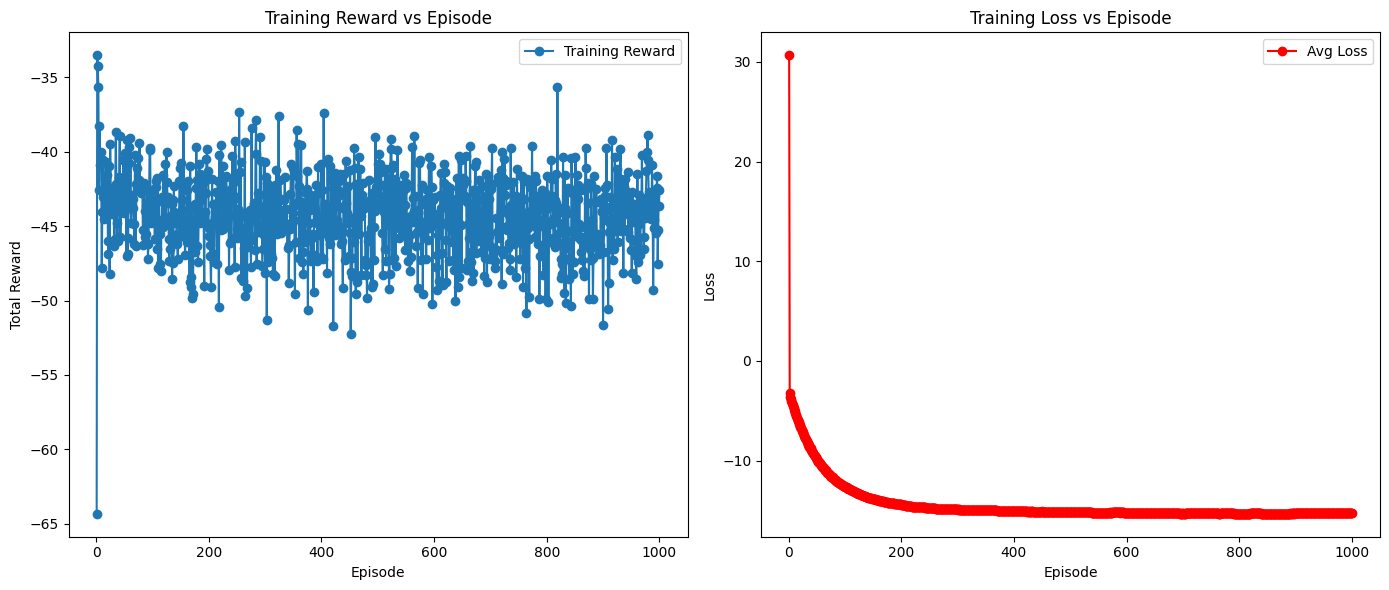

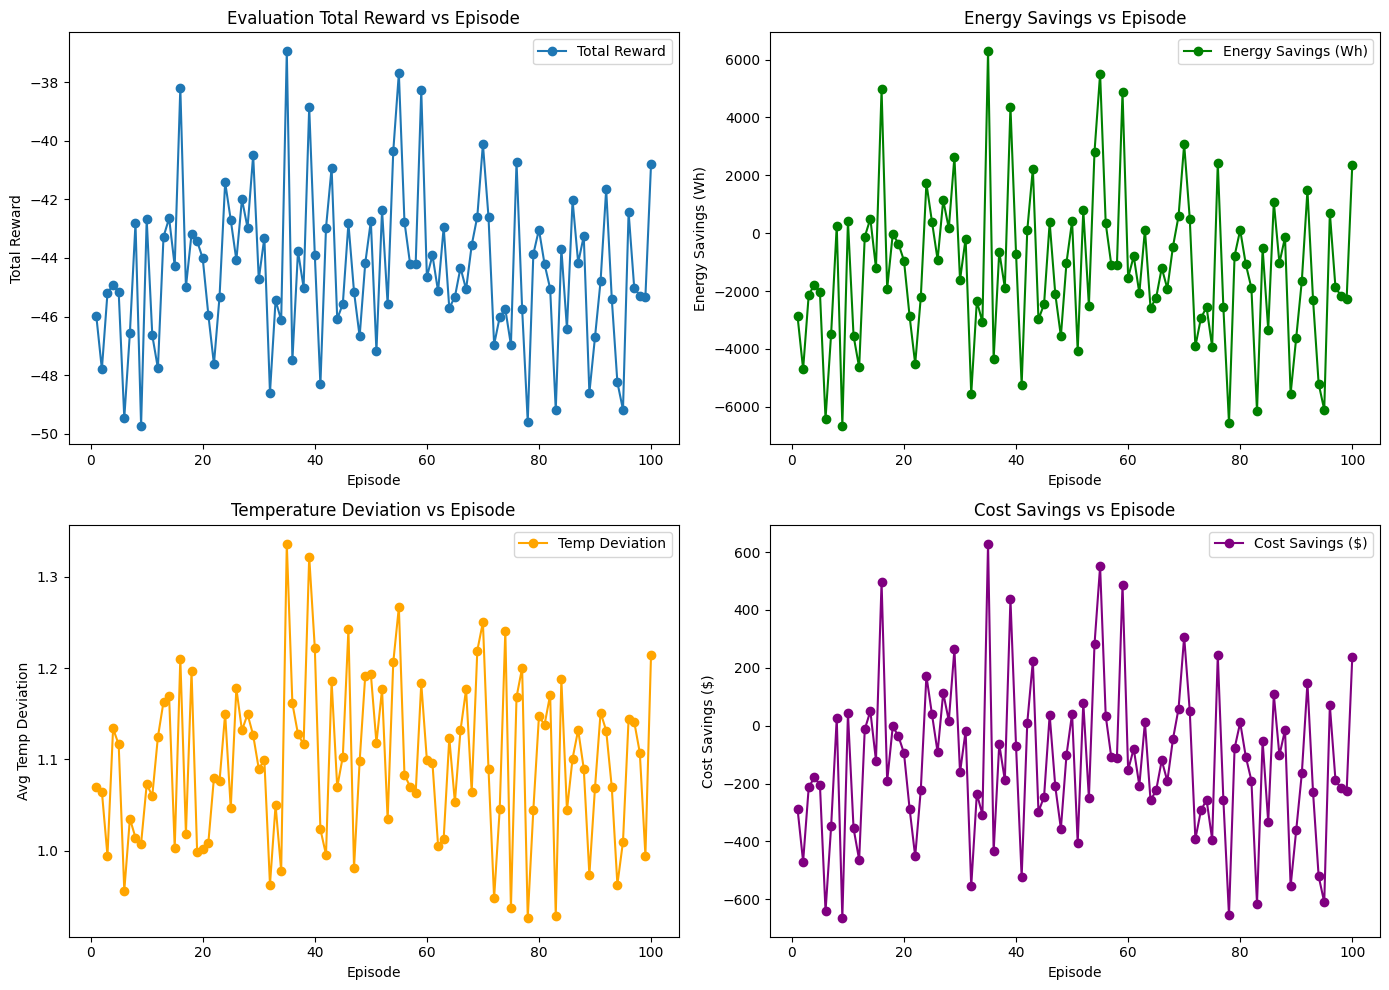

In [10]:
# =============================================================================
# 9. Main Execution: SAC Without HPT/K‑Fold
# =============================================================================
if __name__ == "__main__":
    # ------------- Load and Preprocess the Data -------------
    df = pd.read_csv("raw_data.csv")
    df = preprocess_data(df)
    
    # ------------- Data Split: 70% Train, 15% Test, 15% Validation -------------
    train_data, temp_data = train_test_split(df, test_size=0.30, random_state=42)
    test_data, val_data = train_test_split(temp_data, test_size=0.50, random_state=42)
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    print(f"Validation samples: {len(val_data)}")
    
    # ------------- Create Environments for Each Data Split -------------
    env_train = HVACEnvironment(train_data, desired_temperature=22)
    env_test  = HVACEnvironment(test_data, desired_temperature=22)
    env_val   = HVACEnvironment(val_data, desired_temperature=22)
    
    # ------------- Initialize the SAC Agent -------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_size = env_train.observation_space_shape
    action_size = env_train.action_space_n
    sac_agent = SACAgent(state_size, action_size, device)
    
    # ------------- Train the SAC Agent on the Training Split -------------
    print("\nTraining SAC on training split...")
    train_rewards, train_losses = train_sac(env_train, sac_agent, n_episodes=1000, max_t=500, cost_factor=0.10)
    
    # ------------- Evaluate the Trained SAC Model -------------
    print("\nEvaluating SAC on test split:")
    test_results = evaluate_sac(env_test, sac_agent, n_episodes=100, max_t=500, C_energy=0.10)
    
    print("\nEvaluating SAC on validation split:")
    val_results = evaluate_sac(env_val, sac_agent, n_episodes=100, max_t=500, C_energy=0.10)
    
    # ------------- Plot the Metrics -------------
    plot_training_results(train_rewards, train_losses)
    plot_evaluation_results(test_results)

In [ ]:
# import random
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from collections import deque

# # =============================================================================
# # 1. Data Preprocessing Function
# # =============================================================================
# def preprocess_data(df):
#     # Create occupancy from lights.
#     df['Occupancy'] = df['lights'].apply(lambda x: 1 if x > 0 else 0)
    
#     # Compute average indoor temperature from columns T1 to T9.
#     temp_cols = [f'T{i}' for i in range(1, 10)]
#     df['Avg_T1_T9'] = df[temp_cols].mean(axis=1)
    
#     # Compute HVAC energy consumption as Appliances minus lights.
#     df['HVAC_energy'] = df['Appliances'] - df['lights']
    
#     # Extract hour of day from date.
#     df['date'] = pd.to_datetime(df['date'])
#     df['Hour_of_day'] = df['date'].dt.hour
    
#     # Keep only relevant features.
#     relevant_features = ['Avg_T1_T9', 'T_out', 'Occupancy', 'Hour_of_day', 'HVAC_energy']
#     df = df[relevant_features].copy()
#     df.ffill(inplace=True)
#     return df

# # =============================================================================
# # 2. HVAC Environment (Same as in previous examples)
# # =============================================================================
# class HVACEnvironment:
#     def __init__(self, dataframe, desired_temperature=22):
#         self.df = dataframe.copy()
#         self.desired_temperature = desired_temperature  
#         self.observation_space_shape = self.df.shape[1]  # number of features
#         self.action_space_n = 4  # Discrete actions: 0=Off, 1=Low, 2=Medium, 3=High
#         self.current_step = 0
#         self.max_steps = len(self.df) - 1

#         # (For simulation purposes, we may compute energy thresholds if needed.)
#         self.energy_thresholds = {
#             'Low': self.df['HVAC_energy'].quantile(0.25),
#             'Medium': self.df['HVAC_energy'].quantile(0.5),
#             'High': self.df['HVAC_energy'].quantile(0.75)
#         }
#         self.current_temp = self.df['Avg_T1_T9'].iloc[0]
    
#     def reset(self, start_step=0):
#         self.current_step = start_step
#         self.current_temp = self.df['Avg_T1_T9'].iloc[self.current_step]
#         return self._get_state()
    
#     def _get_state(self):
#         row = self.df.iloc[self.current_step].copy()
#         row['Avg_T1_T9'] = self.current_temp  # use updated temperature
#         return row.values
    
#     def _get_reward(self, action, simulated_energy):
#         lambda_factor = 1  
#         reward = -(simulated_energy + lambda_factor * abs(self.current_temp - self.desired_temperature)) / 1000.0
#         return reward
    
#     def _take_action(self, action):
#         if action == 0:
#             return np.random.uniform(0, 25)
#         elif action == 1:
#             return np.random.uniform(25, 100)
#         elif action == 2:
#             return np.random.uniform(100, 300)
#         elif action == 3:
#             return np.random.uniform(300, 500)
#         else:
#             raise ValueError("Invalid action.")
    
#     def step(self, action):
#         simulated_energy = self._take_action(action)
#         temp_change = (self.desired_temperature - self.current_temp) * 0.05
#         self.current_temp += temp_change * (simulated_energy / 500.0)
#         self.current_step += 1
#         next_state = self._get_state()
#         reward = self._get_reward(action, simulated_energy)
#         done = self.current_step >= self.max_steps
#         return next_state, reward, done, {"HVAC_energy": simulated_energy}

# # =============================================================================
# # 3. Network Definitions for SAC
# # =============================================================================
# # Actor network: outputs logits for a categorical distribution.
# class Actor(nn.Module):
#     def __init__(self, state_size, action_size):
#         super(Actor, self).__init__()
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, action_size)
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         logits = self.fc3(x)
#         return logits

# # Q-network (used for both Q1 and Q2).
# class QNetwork(nn.Module):
#     def __init__(self, state_size, action_size):
#         super(QNetwork, self).__init__()
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, action_size)
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         return self.fc3(x)

# # Value network: outputs a single state value.
# class ValueNetwork(nn.Module):
#     def __init__(self, state_size):
#         super(ValueNetwork, self).__init__()
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 1)
    
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         value = self.fc3(x)
#         return value

# # =============================================================================
# # 4. Replay Buffer (Same as in previous implementations)
# # =============================================================================
# class ReplayBuffer:
#     def __init__(self, capacity):
#         self.buffer = deque(maxlen=capacity)
    
#     def add(self, state, action, reward, next_state, done):
#         self.buffer.append((state, action, reward, next_state, done))
    
#     def sample(self, batch_size):
#         batch = random.sample(self.buffer, batch_size)
#         states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
#         return states, actions, rewards, next_states, dones
    
#     def __len__(self):
#         return len(self.buffer)

# # =============================================================================
# # 5. SAC Agent (Discrete SAC)
# # =============================================================================
# class SACAgent:
#     def __init__(self, state_size, action_size, device):
#         self.state_size = state_size
#         self.action_size = action_size
#         self.device = device
        
#         # Hyperparameters.
#         self.alpha = 0.2      # Entropy temperature constant.
#         self.gamma = 0.99
#         self.tau = 0.005      # For soft target updates.
#         self.batch_size = 64
        
#         # Networks.
#         self.actor = Actor(state_size, action_size).to(device)
#         self.q1 = QNetwork(state_size, action_size).to(device)
#         self.q2 = QNetwork(state_size, action_size).to(device)
#         self.value = ValueNetwork(state_size).to(device)
#         self.target_value = ValueNetwork(state_size).to(device)
#         self.target_value.load_state_dict(self.value.state_dict())
        
#         # Optimizers.
#         self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
#         self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=3e-4)
#         self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=3e-4)
#         self.value_optimizer = optim.Adam(self.value.parameters(), lr=3e-4)
        
#         # Replay Buffer.
#         self.memory = ReplayBuffer(10000)
    
#     def select_action(self, state):
#         state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
#         logits = self.actor(state_tensor)
#         probs = torch.softmax(logits, dim=-1)
#         dist = torch.distributions.Categorical(probs)
#         action = dist.sample()
#         return action.item()
    
#     def store(self, state, action, reward, next_state, done):
#         self.memory.add(state, action, reward, next_state, done)
    
#     def update_parameters(self):
#         if len(self.memory) < self.batch_size:
#             return None
        
#         # Sample a batch.
#         states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
#         states = torch.FloatTensor(np.array(states)).to(self.device)
#         actions = torch.LongTensor(np.array(actions)).unsqueeze(1).to(self.device)
#         rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(self.device)
#         next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
#         dones = torch.FloatTensor(np.array(dones).astype(np.uint8)).unsqueeze(1).to(self.device)
        
#         # --- Q Update ---
#         # Get Q values for actions taken.
#         q1_values = self.q1(states).gather(1, actions)
#         q2_values = self.q2(states).gather(1, actions)
        
#         with torch.no_grad():
#             # Use target value network for next state V_target.
#             target_v = self.target_value(next_states)
#             target_q = rewards + self.gamma * target_v * (1 - dones)
        
#         q1_loss = nn.MSELoss()(q1_values, target_q)
#         q2_loss = nn.MSELoss()(q2_values, target_q)
        
#         self.q1_optimizer.zero_grad()
#         q1_loss.backward()
#         self.q1_optimizer.step()
        
#         self.q2_optimizer.zero_grad()
#         q2_loss.backward()
#         self.q2_optimizer.step()
        
#         # --- Value Update ---
#         logits = self.actor(states)
#         probs = torch.softmax(logits, dim=-1)
#         log_probs = torch.log_softmax(logits, dim=-1)
#         q1_all = self.q1(states)
#         q2_all = self.q2(states)
#         min_q = torch.min(q1_all, q2_all)
#         # Compute the soft value target: sum_a pi(a|s)[ min(Q1, Q2)(s,a) - alpha * log(pi(a|s)) ]
#         value_target = (probs * (min_q - self.alpha * log_probs)).sum(dim=1, keepdim=True)
#         value_loss = nn.MSELoss()(self.value(states), value_target.detach())
        
#         self.value_optimizer.zero_grad()
#         value_loss.backward()
#         self.value_optimizer.step()
        
#         # --- Policy (Actor) Update ---
#         # Policy loss: expectation over actions: sum_a pi(a|s)[ alpha*log(pi(a|s)) - min(Q1,Q2)(s,a) ]
#         policy_loss = (probs * (self.alpha * log_probs - min_q)).sum(dim=1).mean()
        
#         self.actor_optimizer.zero_grad()
#         policy_loss.backward()
#         self.actor_optimizer.step()
        
#         # --- Soft Update the Target Value Network ---
#         for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
#             target_param.data.copy_(self.tau * param.data + (1 - self.tau)*target_param.data)
        
#         total_loss = q1_loss.item() + q2_loss.item() + value_loss.item() + policy_loss.item()
#         return total_loss

# # =============================================================================
# # 6A. Training Function for SAC with Extra Evaluation Metrics
# # =============================================================================
# def train_sac(env, agent, n_episodes=100, max_t=1000, cost_factor=0.10):
#     episode_rewards = []
#     episode_losses = []
    
#     for episode in range(n_episodes):
#         state = env.reset()
#         total_reward = 0.0
#         t = 0
#         baseline_energy_sum = 0.0
#         rl_energy_sum = 0.0
#         temp_deviation_sum = 0.0
#         losses = []
        
#         for t in range(max_t):
#             # For evaluation metrics.
#             baseline_energy_sum += state[-1]
#             temp_deviation_sum += abs(state[0] - env.desired_temperature)
            
#             action = agent.select_action(state)
#             next_state, reward, done, info = env.step(action)
#             rl_energy_sum += info.get("HVAC_energy", 0.0)
#             agent.store(state, action, reward, next_state, done)
#             total_reward += reward
#             state = next_state
            
#             loss = agent.update_parameters()
#             if loss is not None:
#                 losses.append(loss)
#             if done:
#                 break
        
#         avg_loss = np.mean(losses) if losses else 0.0
#         episode_rewards.append(total_reward)
#         episode_losses.append(avg_loss)
#         energy_savings = baseline_energy_sum - rl_energy_sum
#         avg_temp_deviation = temp_deviation_sum / (t + 1)
#         cost_savings = energy_savings * cost_factor
        
#         print(f"Episode {episode+1:3d} | Steps: {t+1:4d} | Total Reward: {total_reward:9.2f} | "
#               f"Avg Loss: {avg_loss:8.4f}")
#         print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
#               f"Cost Savings ($): {cost_savings:6.2f}")
        
#     return episode_rewards, episode_losses

# # =============================================================================
# # 6B. Evaluation Function for SAC with Extra Metrics
# # =============================================================================
# def evaluate_sac(env, agent, n_episodes=10, max_t=1000, C_energy=0.10):
#     results = []
#     for episode in range(n_episodes):
#         state = env.reset()
#         total_reward = 0.0
#         t = 0
#         baseline_energy_sum = 0.0
#         rl_energy_sum = 0.0
#         temp_deviation_sum = 0.0
#         done = False
        
#         while not done and t < max_t:
#             baseline_energy_sum += state[-1]
#             temp_deviation_sum += abs(state[0] - env.desired_temperature)
#             action = agent.select_action(state)
#             state, reward, done, info = env.step(action)
#             rl_energy_sum += info.get("HVAC_energy", 0.0)
#             total_reward += reward
#             t += 1
        
#         energy_savings = baseline_energy_sum - rl_energy_sum
#         avg_temp_deviation = temp_deviation_sum / (t+1) if t > 0 else 0.0
#         cost_savings = energy_savings * C_energy
        
#         print(f"Eval Episode {episode+1:3d} | Steps: {t:4d} | Total Reward: {total_reward:9.2f}")
#         print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
#               f"Cost Savings ($): {cost_savings:6.2f}")
#         print("--------------------------------------------------------------")
#         results.append({
#             "episode": episode+1,
#             "steps": t,
#             "total_reward": total_reward,
#             "energy_savings": energy_savings,
#             "avg_temp_deviation": avg_temp_deviation,
#             "cost_savings": cost_savings
#         })
#     return results

# # =============================================================================
# # 7. Plotting Functions for Training and Evaluation Metrics
# # =============================================================================
# def plot_training_results(rewards, losses):
#     episodes = np.arange(1, len(rewards)+1)
#     plt.figure(figsize=(14,6))
    
#     plt.subplot(1,2,1)
#     plt.plot(episodes, rewards, marker='o', label='Training Reward')
#     plt.xlabel("Episode")
#     plt.ylabel("Total Reward")
#     plt.title("Training Reward vs Episode")
#     plt.legend()
    
#     plt.subplot(1,2,2)
#     plt.plot(episodes, losses, marker='o', color='red', label='Avg Loss')
#     plt.xlabel("Episode")
#     plt.ylabel("Loss")
#     plt.title("Training Loss vs Episode")
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# def plot_evaluation_results(eval_results):
#     episodes = [res["episode"] for res in eval_results]
#     total_rewards = [res["total_reward"] for res in eval_results]
#     energy_savings = [res["energy_savings"] for res in eval_results]
#     temp_deviations = [res["avg_temp_deviation"] for res in eval_results]
#     cost_savings = [res["cost_savings"] for res in eval_results]
    
#     plt.figure(figsize=(14,10))
    
#     plt.subplot(2,2,1)
#     plt.plot(episodes, total_rewards, marker='o', label='Total Reward')
#     plt.xlabel("Episode")
#     plt.ylabel("Total Reward")
#     plt.title("Evaluation Total Reward vs Episode")
#     plt.legend()
    
#     plt.subplot(2,2,2)
#     plt.plot(episodes, energy_savings, marker='o', color='green', label='Energy Savings (Wh)')
#     plt.xlabel("Episode")
#     plt.ylabel("Energy Savings (Wh)")
#     plt.title("Energy Savings vs Episode")
#     plt.legend()
    
#     plt.subplot(2,2,3)
#     plt.plot(episodes, temp_deviations, marker='o', color='orange', label='Temp Deviation')
#     plt.xlabel("Episode")
#     plt.ylabel("Avg Temp Deviation")
#     plt.title("Temperature Deviation vs Episode")
#     plt.legend()
    
#     plt.subplot(2,2,4)
#     plt.plot(episodes, cost_savings, marker='o', color='purple', label='Cost Savings ($)')
#     plt.xlabel("Episode")
#     plt.ylabel("Cost Savings ($)")
#     plt.title("Cost Savings vs Episode")
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# # =============================================================================
# # 8. Hyperparameter Tuning with K‑Fold Cross Validation for DDQN (Optional)
# # For SAC, we are not performing HPT/co-fold tuning in this code.
# # =============================================================================

# # =============================================================================
# # 9. Main Execution: SAC Without HPT/K‑Fold
# # =============================================================================
# if __name__ == "__main__":
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Load and preprocess data.
#     df = pd.read_csv("raw_data.csv")
#     df = preprocess_data(df)
    
#     # Create HVAC environment.
#     env = HVACEnvironment(df, desired_temperature=22)
#     state_size = env.observation_space_shape
#     action_size = env.action_space_n  # discrete SAC
#     # Initialize SAC agent.
#     agent = SACAgent(state_size, action_size, device)
    
#     # Train SAC agent.
#     n_train_episodes = 50  # adjust as needed
#     train_rewards, train_losses = train_sac(env, agent, n_episodes=n_train_episodes, max_t=1000, cost_factor=0.10)
    
#     # Evaluate SAC agent.
#     n_eval_episodes = 10
#     eval_results = evaluate_sac(env, agent, n_episodes=n_eval_episodes, max_t=1000, C_energy=0.10)
    
#     # Plot training and evaluation metrics.
#     plot_training_results(train_rewards, train_losses)
#     plot_evaluation_results(eval_results)
    
#     plt.show()
